Baseline model on SNLI tested on Function Words and Semantic Fragments Adversarial Data (here is the combined version)

In [ ]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import os
os.environ["WANDB_DISABLED"] = "true"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/experiments_data/

Mounted at /content/drive
adversarial_data.csv		  high_level_phenomena.csv	small_snli_dev_3k.csv
adversarial_data_final.csv	  logs				small_snli_test_1.5k.csv
adversarial_predictions.csv	  low_level_phenomena.csv	small_snli_test_3k.csv
adversarial_predictions_test.csv  model				small_snli_train_15k.csv
baseline_model_output		  model_output			small_snli_train_20k.csv
distilbert_baseline_snli_output   model_outputs			snli_1.0_dev.txt
distilbert_output		  multinli_1.0_dev_matched.csv	snli_1.0_test.txt
filtered_for_reasoning.csv	  multinli_1.0_train.csv	snli_dev.csv
final_adversarial_data.csv	  predictions_output.csv	snli_test.csv
final_baseline_model_output	  small_snli_dev_1.5k.csv	snli_train.csv


In [ ]:
def prepare_dataframe(file_path):
    """
    Reads the CSV file, processes it, and returns a DataFrame with 'input_text', 'label',
    and 'targeted_phenomenon' columns.
    """
    df = pd.read_csv(file_path)
    print(f"\nInitial DataFrame from {file_path}:\n")
    print(df.head())

    # connects premise&hypothesis
    df['input_text'] = df['sentence1'] + " [SEP] " + df['sentence2']

    #label mapping
    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
    df['label'] = df['gold_label'].map(label_mapping)

    df = df[['input_text', 'label', 'targeted_phenomenon']].dropna()

    print("\nDataFrame after processing:\n")
    print(df.head())

    return df

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding="max_length", truncation=True)

In [ ]:
#metrics by 'targeted_phenomenon'
def evaluate_with_phenomena(trainer, dataset, label_list, output_csv="evaluation_results.csv", predictions_csv_path=None):

    predictions, labels, _ = trainer.predict(dataset)
    pred_labels = np.argmax(predictions, axis=1)
    labels = labels.astype(int)
    pred_labels = pred_labels.astype(int)

    #report
    print("\nOverall Classification Report:")
    print(classification_report(labels, pred_labels, target_names=label_list))

    #matrix
    cf_matrix = confusion_matrix(labels, pred_labels)
    print("\nOverall Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_list).plot()
    plt.show()

    #df
    dataset_df = pd.DataFrame({
        'input_text': dataset['input_text'],
        'true_label': labels,
        'predicted_label': pred_labels,
        'targeted_phenomenon': dataset['targeted_phenomenon']
    })

    #maps numeric labels to their corresponding string labels for display
    reverse_label_mapping = {0: "neutral", 1: "contradiction", 2: "entailment"}
    dataset_df['true_label_str'] = dataset_df['true_label'].map(reverse_label_mapping)
    dataset_df['predicted_label_str'] = dataset_df['predicted_label'].map(reverse_label_mapping)


    if predictions_csv_path:
        dataset_df.to_csv(predictions_csv_path, index=False)
        print(f"\nDetailed predictions saved to {predictions_csv_path}")

    #goups by 'targeted_phenomenon' and computes metrics
    phenomena_groups = dataset_df.groupby('targeted_phenomenon')

    for phenomenon, group in phenomena_groups:
        print(f"\nClassification Report for Targeted Phenomenon: {phenomenon}")
        report = classification_report(
            group['true_label'],
            group['predicted_label'],
            target_names=label_list,
            zero_division=0
        )
        print(report)

        cf_matrix = confusion_matrix(group['true_label'], group['predicted_label'], labels=[0, 1, 2])
        ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_list).plot()
        plt.title(f"Confusion Matrix for {phenomenon}")
        plt.show()


In [ ]:
adversarial_test_path = '/content/drive/MyDrive/experiments_data/final_adversarial_data.csv'
df_adversarial_test = prepare_dataframe(adversarial_test_path)
print("\nProcessed Adversarial Test DataFrame head:")
print(df_adversarial_test.head())


adversarial_test_dataset = Dataset.from_pandas(df_adversarial_test)

#tokenizing
adversarial_test_dataset = adversarial_test_dataset.map(tokenize_function, batched=True)
adversarial_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Initial DataFrame from /content/drive/MyDrive/experiments_data/final_adversarial_data.csv:

  targeted_phenomenon     gold_label  id  \
0        comparatives  contradiction   1   
1        comparatives     entailment   2   
2        comparatives  contradiction   3   
3        comparatives     entailment   4   
4        comparatives     entailment   5   

                                           sentence1  \
0  The member countries have more people and expo...   
1  The member countries have more people and expo...   
2  An ACI system requires much less in terms of s...   
3  An ACI system requires much less in terms of s...   
4  We received and considered more than 200 comme...   

                                           sentence2  
0  The United States has not a larger gross domes...  
1  The United States has a larger gross domestic ...  
2  The ACI system is more resource-intensive than...  
3  The ACI system is not more resource-intensive ...  
4   There were not less than 1

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Evaluating on adversarial test dataset...



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.34      0.24      0.28       180
contradiction       0.42      0.69      0.53       280
   entailment       0.50      0.26      0.34       260

     accuracy                           0.42       720
    macro avg       0.42      0.40      0.38       720
 weighted avg       0.43      0.42      0.40       720


Overall Confusion Matrix:


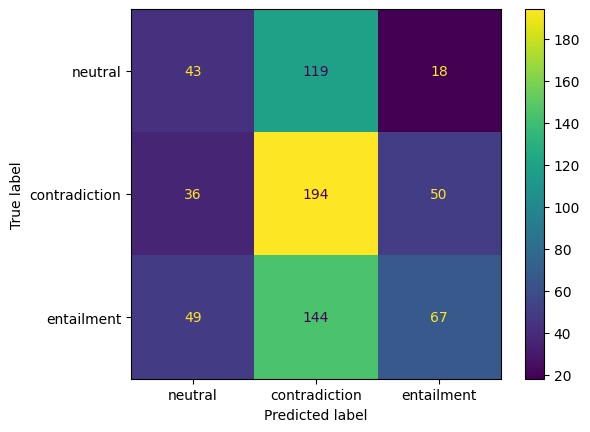


Classification Report for Targeted Phenomenon: boolean
               precision    recall  f1-score   support

      neutral       0.00      0.00      0.00        29
contradiction       0.39      1.00      0.56        31
   entailment       0.00      0.00      0.00        20

     accuracy                           0.39        80
    macro avg       0.13      0.33      0.19        80
 weighted avg       0.15      0.39      0.22        80



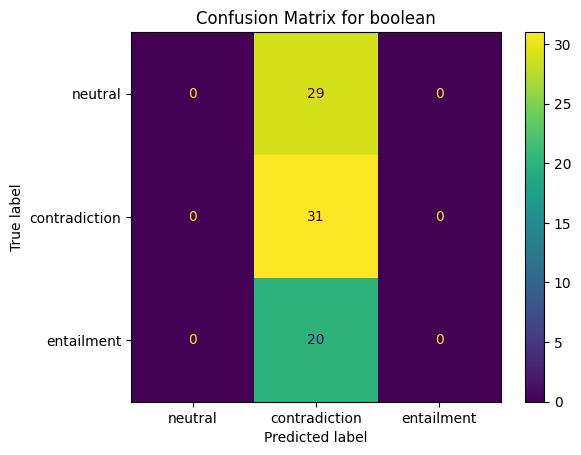


Classification Report for Targeted Phenomenon: comparatives
               precision    recall  f1-score   support

      neutral       0.00      0.00      0.00         4
contradiction       0.45      0.47      0.46        40
   entailment       0.50      0.44      0.47        36

     accuracy                           0.44        80
    macro avg       0.32      0.31      0.31        80
 weighted avg       0.45      0.44      0.44        80



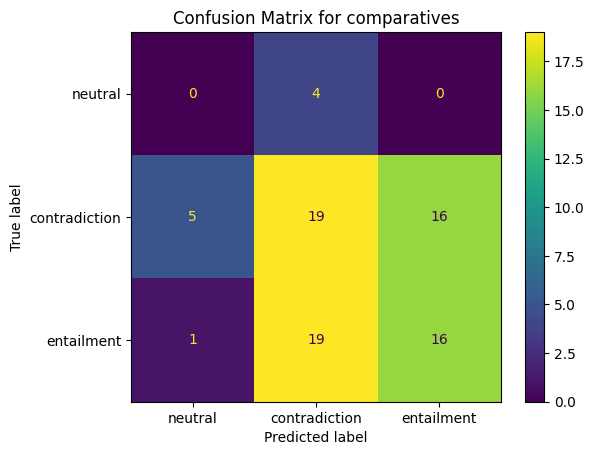


Classification Report for Targeted Phenomenon: conditionals
               precision    recall  f1-score   support

      neutral       0.30      0.12      0.17        25
contradiction       0.48      0.94      0.64        33
   entailment       0.33      0.09      0.14        22

     accuracy                           0.45        80
    macro avg       0.37      0.38      0.32        80
 weighted avg       0.39      0.45      0.36        80



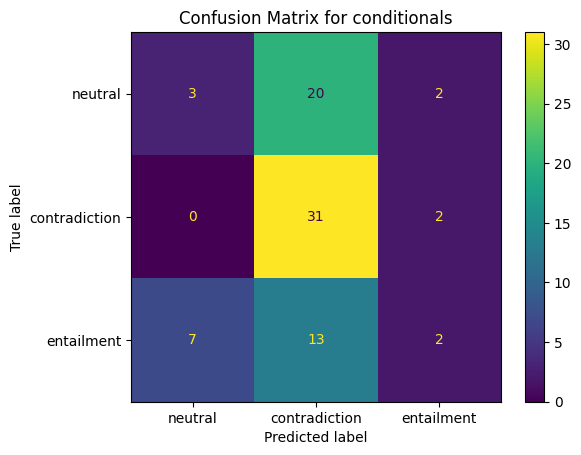


Classification Report for Targeted Phenomenon: counting
               precision    recall  f1-score   support

      neutral       0.34      0.33      0.34        30
contradiction       0.43      0.65      0.52        31
   entailment       0.80      0.21      0.33        19

     accuracy                           0.42        80
    macro avg       0.53      0.40      0.40        80
 weighted avg       0.49      0.42      0.41        80



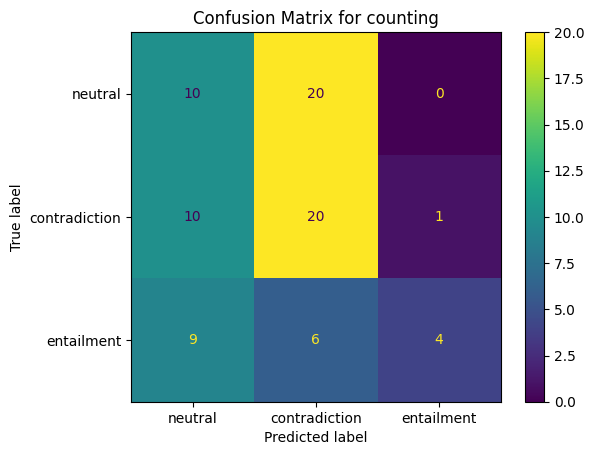


Classification Report for Targeted Phenomenon: monotonicity
               precision    recall  f1-score   support

      neutral       0.56      0.34      0.43        29
contradiction       0.55      0.71      0.62        24
   entailment       0.42      0.48      0.45        27

     accuracy                           0.50        80
    macro avg       0.51      0.51      0.50        80
 weighted avg       0.51      0.50      0.49        80



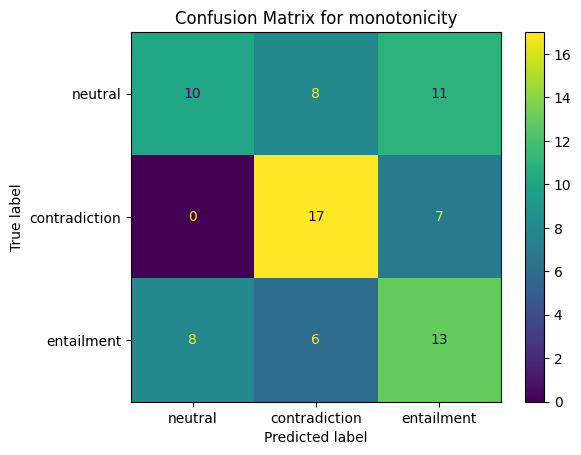


Classification Report for Targeted Phenomenon: negation
               precision    recall  f1-score   support

      neutral       0.00      0.00      0.00        25
contradiction       0.30      1.00      0.46        24
   entailment       0.00      0.00      0.00        31

     accuracy                           0.30        80
    macro avg       0.10      0.33      0.15        80
 weighted avg       0.09      0.30      0.14        80



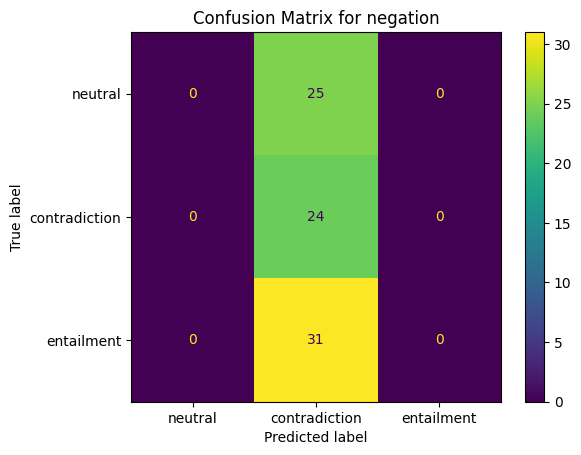


Classification Report for Targeted Phenomenon: prepositions
               precision    recall  f1-score   support

      neutral       0.38      0.72      0.49        25
contradiction       0.33      0.23      0.27        22
   entailment       0.47      0.24      0.32        33

     accuracy                           0.39        80
    macro avg       0.39      0.40      0.36        80
 weighted avg       0.40      0.39      0.36        80



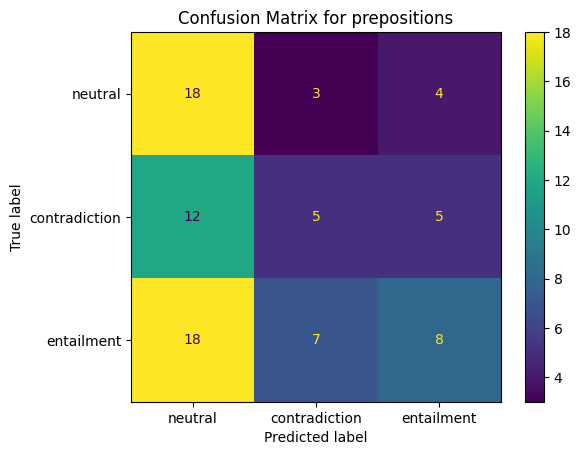


Classification Report for Targeted Phenomenon: quantification
               precision    recall  f1-score   support

      neutral       0.12      0.20      0.15         5
contradiction       0.55      0.63      0.59        38
   entailment       0.61      0.46      0.52        37

     accuracy                           0.53        80
    macro avg       0.43      0.43      0.42        80
 weighted avg       0.55      0.53      0.53        80



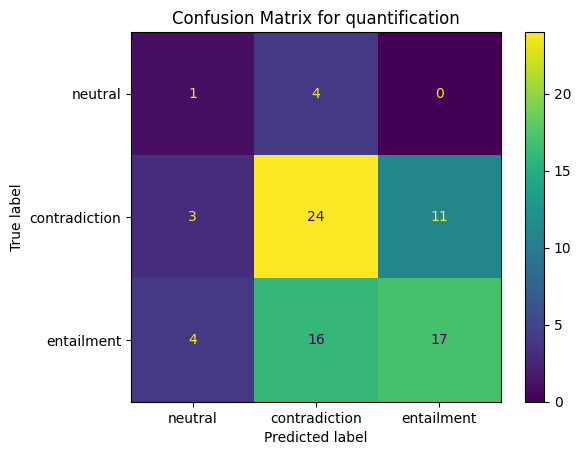


Classification Report for Targeted Phenomenon: spatial data
               precision    recall  f1-score   support

      neutral       0.11      0.12      0.12         8
contradiction       0.42      0.62      0.50        37
   entailment       0.44      0.20      0.27        35

     accuracy                           0.39        80
    macro avg       0.32      0.32      0.30        80
 weighted avg       0.40      0.39      0.36        80



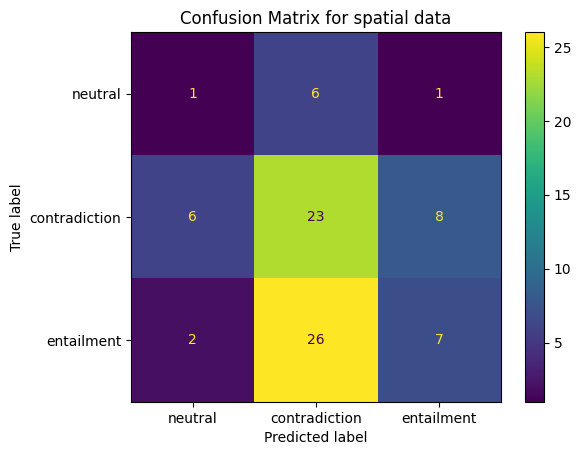

In [ ]:
#loading the trained model and tokenizer
model_path = "/content/drive/MyDrive/experiments_data/model_outputs/distilbert_snli_baseline/final_baseline_saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

trainer = Trainer(model=model, tokenizer=tokenizer)

# evaluation on the adversarial test dataset with targeted phenomenon analysis
label_list = ["neutral", "contradiction", "entailment"]
output_csv_path = "/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/baseline_adversarial/baseline_adversarial_results.csv"
print("\nEvaluating on adversarial test dataset...")
evaluate_with_phenomena(trainer, adversarial_test_dataset, label_list, output_csv=output_csv_path)

In [ ]:
#for more concentarted table

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Evaluating on adversarial test dataset...



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.34      0.24      0.28       180
contradiction       0.42      0.69      0.53       280
   entailment       0.50      0.26      0.34       260

     accuracy                           0.42       720
    macro avg       0.42      0.40      0.38       720
 weighted avg       0.43      0.42      0.40       720


Overall Confusion Matrix:


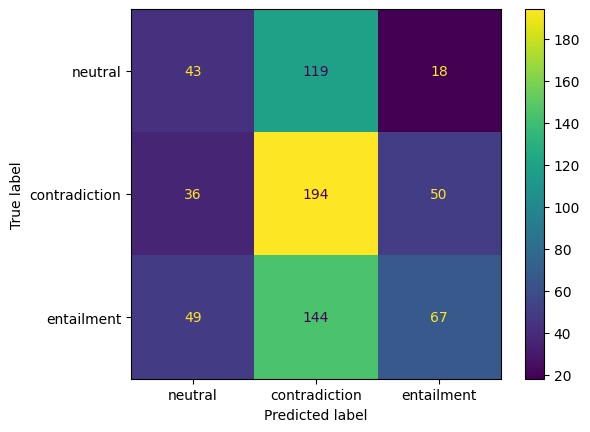


Summary Table for All Targeted Phenomena:
       Phenomenon  Precision (weighted avg)  Recall (weighted avg)  \
7  quantification                  0.547707                 0.5250   
4    monotonicity                  0.507437                 0.5000   
1    comparatives                  0.451190                 0.4375   
3        counting                  0.487789                 0.4250   
8    spatial data                  0.395926                 0.3875   
6    prepositions                  0.402972                 0.3875   
2    conditionals                  0.385221                 0.4500   
0         boolean                  0.150156                 0.3875   
5        negation                  0.090000                 0.3000   

   F1-score (weighted avg)  
7                 0.529587  
4                 0.491003  
1                 0.443472  
3                 0.407584  
8                 0.363113  
6                 0.360434  
2                 0.356517  
0                 0.2164

In [ ]:
def evaluate_with_phenomena(trainer, dataset, label_list, output_csv_path=None, predictions_csv_path=None):
    predictions, labels, _ = trainer.predict(dataset)
    pred_labels = np.argmax(predictions, axis=1)

    print("\nOverall Classification Report:")
    print(classification_report(labels, pred_labels, target_names=label_list))

    cf_matrix = confusion_matrix(labels, pred_labels)
    print("\nOverall Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_list).plot()
    plt.show()

    dataset_df = pd.DataFrame({
        'input_text': dataset['input_text'],
        'label': labels,
        'pred_label': pred_labels,
        'targeted_phenomenon': dataset['targeted_phenomenon']
    })

    if predictions_csv_path:
        dataset_df.to_csv(predictions_csv_path, index=False)
        print(f"\nDetailed predictions saved to '{predictions_csv_path}'")

    summary_table = []

    phenomena_groups = dataset_df.groupby('targeted_phenomenon')

    for phenomenon, group in phenomena_groups:
        report = classification_report(
            group['label'],
            group['pred_label'],
            target_names=label_list,
            output_dict=True,
            zero_division=0
        )

        summary_table.append({
            'Phenomenon': phenomenon,
            'Precision (weighted avg)': report['weighted avg']['precision'],
            'Recall (weighted avg)': report['weighted avg']['recall'],
            'F1-score (weighted avg)': report['weighted avg']['f1-score']
        })


    summary_df = pd.DataFrame(summary_table)
    summary_df = summary_df.sort_values(by='F1-score (weighted avg)', ascending=False)

    print("\nSummary Table for All Targeted Phenomena:")
    print(summary_df)

    if output_csv_path:
        summary_df.to_csv(output_csv_path, index=False)
        print(f"\nSummary table saved to '{output_csv_path}'")
#saving
output_csv_path = "/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/baseline_adversarial/summary_results.csv"
predictions_csv_path = "/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/baseline_adversarial/detailed_predictions.csv"

#training the model and tokenizer
model_path = "/content/drive/MyDrive/experiments_data/model_outputs/distilbert_snli_baseline/final_baseline_saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

trainer = Trainer(model=model, tokenizer=tokenizer)

label_list = ["neutral", "contradiction", "entailment"]

print("\nEvaluating on adversarial test dataset...")
summary_df = evaluate_with_phenomena(trainer, adversarial_test_dataset, label_list, output_csv_path, predictions_csv_path)
